In [174]:
import networkx as nx
import numpy as np
import itertools as it
import itertools
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
%matplotlib inline

# Needed functions from previous task

In [175]:
def tpCalc(l,n,c):
    tp=0
    for i in range(len(l)):
        if l[i]>1:
            tp+=(l[i]*(l[i]-1))/2
        else:
            continue
        if n[i]>1:
            tp+=(n[i]*(n[i]-1))/2
        else:
            continue
        if c[i]>1:
            tp+=(c[i]*(c[i]-1))/2
        else:
            continue
    return tp

In [176]:
def fpCalc(l,n,c):
    fp=0
    array=[]
    for i in range(len(l)):
        array.append([l[i],n[i],c[i]])
    
    fp=0
    for i in array:
        multiplier=0
        for j in range(len(i)):
            if i[j]==0:
                continue
            else:
                for m in range(j+1,len(i)):
                    multiplier+=i[j]*i[m]
        fp+=multiplier
    return fp

In [177]:
def fnCalc(l,n,c):
    fn=0
    array=[l,n,c]
    for i in array:
        multiplier=0
        for j in range(len(i)):
            if i[j]==0:
                continue
            else:
                for m in range(j+1,len(i)):
                    multiplier+=i[j]*i[m]
        fn+=multiplier
    return fn

In [178]:
def purityCalc(l,n,c):
    purity=0
    array=[]
    summation=[]
    maximum=[]
    for i in range(len(l)):
        array.append([l[i],n[i],c[i]])
    for j in array:
        summation.append(sum(j))
        maximum.append(max(j))
    purity=sum(maximum)/sum(summation)
    return purity

In [179]:
def searchCommunity(dictionary,communities):
    l=[0 for i in range(len(communities))]
    c=[0 for i in range(len(communities))]
    n=[0 for i in range(len(communities))]
    for i in communities:
        for j in i:
            if dictionary[j]["value"]=="l":
                l[communities.index(i)]+=1
            elif dictionary[j]["value"]=="n":
                n[communities.index(i)]+=1
            elif dictionary[j]["value"]=="c":
                c[communities.index(i)]+=1
            else:
                continue
                
    tp=tpCalc(l,n,c)
    fp=fpCalc(l,n,c)
    fn=fnCalc(l,n,c)
    purity=purityCalc(l,n,c)
    
    
    return purity

# Our network

In [180]:
H = nx.read_gml("./polbooks.gml", label='id')
if nx.is_connected(nx.Graph(H))==False:
    G=nx.Graph(H).subgraph(max(nx.connected_components(nx.Graph(H)), key=len))
else:
    G=nx.Graph(H)
print(G.nodes())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]


In [181]:
def groundTruth(dictionary):
    clustLib=[]
    clustNeu=[]
    clustCons=[]
    for i in dictionary:
        if (dictionary[i]["value"])=="l":
            clustLib.append(i)
        elif (dictionary[i]["value"])=="n":
            clustNeu.append(i)
        else:
            clustCons.append(i)
    communities=[clustLib,clustNeu,clustCons]
    return communities
    

communities=groundTruth(G.nodes)

In [182]:
print(communities)

[[30, 31, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102], [0, 4, 6, 7, 18, 28, 46, 48, 51, 69, 76, 103, 104], [1, 2, 3, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 49, 50, 52, 53, 54, 55, 56, 57, 58, 77]]


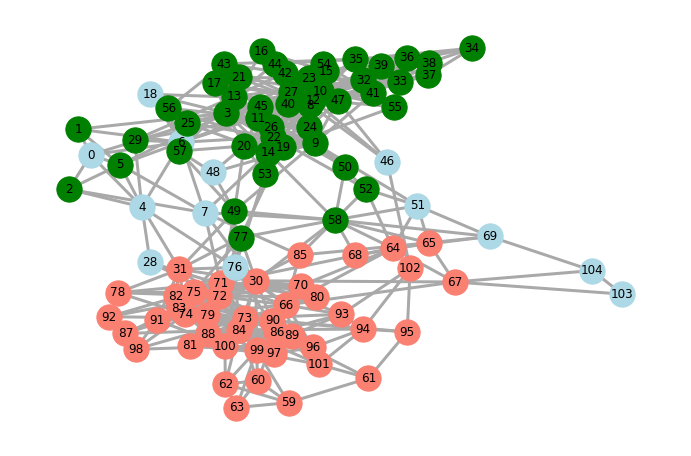

In [183]:
def plot(G,communities,colors):
    pos = nx.spring_layout(G) 
    plt.figure(figsize=(12,8))
    nx.draw_networkx_edges(G, pos=pos, width=3, edge_color='darkgray')
    for community, color in zip(communities, colors):
        nx.draw_networkx_nodes(G, pos=pos, nodelist=community, node_color=color, node_size=640)
    nx.draw_networkx_labels(G, pos=pos)
    _ = plt.axis('off')
    
    
colors=['salmon', 'lightblue', 'green']
plot(G,communities,colors)

# First Node2Vec

### Node2Vec training

In [184]:
node2vec1 = Node2Vec(G,num_walks=80, dimensions=64, p=1,q=2)

Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████| 80/80 [00:58<00:00,  1.36it/s]


In [185]:
model1 = node2vec1.fit(window=10, min_count=1, batch_words=4)

In [186]:
model1.wv.save_word2vec_format("./model1.txt")

In [187]:
df1 = pd.read_csv('./model1.txt', sep='\s+', index_col=0, header=None, skiprows=1)

In [188]:
df1.index.name = 'named_entity'
print(df1)

                    1         2         3         4         5         6   \
named_entity                                                               
8             0.442510 -0.112034 -0.316563  0.232865 -0.065989  0.430225   
12            0.072042 -0.343061 -0.149372  0.004083 -0.195254  0.366129   
84           -0.159049 -0.060242 -0.178303  0.177566 -0.134364 -0.068807   
3             0.105277 -0.113530 -0.172547  0.040455 -0.070067  0.253795   
73           -0.170342 -0.067889 -0.188628  0.086245  0.034594  0.145624   
...                ...       ...       ...       ...       ...       ...   
92           -0.098144 -0.067515  0.093303  0.548560 -0.011005  0.003386   
28            0.013674  0.098542 -0.127342  0.107264  0.241092 -0.086951   
104          -0.112603  0.021959 -0.128643  0.704970 -0.005417 -0.117286   
50           -0.162571 -0.260990 -0.122825  0.359919 -0.009975  0.171203   
103          -0.065564 -0.032659 -0.171470  0.649802 -0.049147 -0.022665   

           

### K Means Clustering

In [189]:
kmeans1 = KMeans(n_clusters=3)

In [190]:
kmeans1.fit(df1)

KMeans(n_clusters=3)

In [191]:
labels = kmeans1.predict(df1)

In [192]:
df1['cluster'] = labels

In [193]:
clusters_df1 = df1.reset_index()[['named_entity','cluster']]

In [194]:
print(clusters_df1)

     named_entity  cluster
0               8        0
1              12        0
2              84        2
3               3        0
4              73        2
..            ...      ...
100            92        2
101            28        2
102           104        1
103            50        0
104           103        1

[105 rows x 2 columns]


### Evaluation

First we get the partition from KMeans algorithm

In [195]:
partition1=[[],[],[]]
for i in range(len(clusters_df1['cluster'])):
    if int(clusters_df1['cluster'][i])==0:
        partition1[0].append(int(clusters_df1['named_entity'][i]))
    elif int(clusters_df1['cluster'][i])==1:
        partition1[1].append(int(clusters_df1['named_entity'][i]))
    else:
        partition1[2].append(int(clusters_df1['named_entity'][i]))

print(partition1)

[[8, 12, 3, 11, 40, 47, 9, 10, 13, 6, 20, 35, 24, 26, 27, 33, 14, 23, 41, 39, 4, 5, 49, 38, 37, 22, 0, 54, 45, 42, 44, 15, 17, 32, 21, 34, 25, 53, 19, 36, 57, 43, 1, 48, 55, 2, 46, 29, 56, 18, 16, 50], [58, 64, 65, 7, 51, 67, 69, 85, 52, 68, 104, 103], [84, 73, 72, 66, 30, 75, 74, 86, 71, 76, 99, 100, 31, 82, 79, 83, 91, 93, 70, 94, 77, 89, 97, 96, 62, 60, 78, 88, 98, 101, 59, 90, 87, 63, 80, 95, 81, 102, 61, 92, 28]]


#### Modularity

In [196]:
print(nx.algorithms.community.modularity(G,partition1))

0.5017482427589328


#### Conductance


In [197]:
print(min(nx.algorithms.cuts.conductance(G, cluster_i, weight='weight') for cluster_i in partition1))

0.043478260869565216


#### Purity

In [198]:
purity=searchCommunity(G.nodes,partition1)
print(purity)

0.8476190476190476


### Visualisation

In [199]:
embedding = np.array(df1.iloc[:,:-1].values.tolist())
ids=df1.index.tolist()
node_targets = [G.nodes[int(node_id)]['value'] for node_id in ids]

In [200]:
tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random')
node_2d_emb=tsne.fit_transform(embedding)

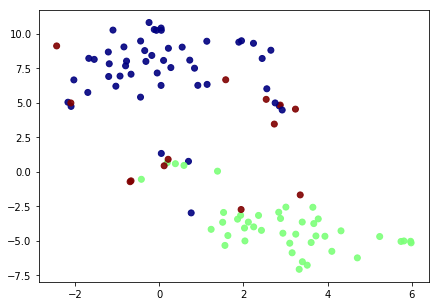

In [201]:
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]
plt.figure(figsize=(7,5))
plt.scatter(node_2d_emb[:,0],node_2d_emb[:,1],c=node_colours, cmap="jet", alpha=0.9)


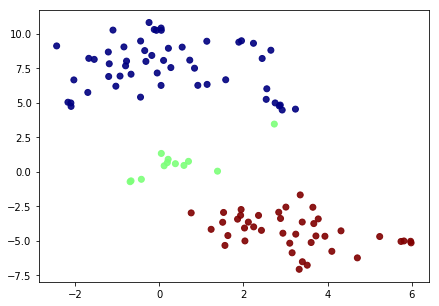

In [202]:
label_map = { l: i for i, l in enumerate(np.unique(df1['cluster']))}
node_colours = [ label_map[target] for target in df1['cluster']]
plt.figure(figsize=(7,5))
plt.scatter(node_2d_emb[:,0],node_2d_emb[:,1],c=node_colours, cmap="jet", alpha=0.9)

# Second Node2Vec

### Node2Vec training

In [203]:
node2vec2 = Node2Vec(G,num_walks=80, dimensions=64, p=1,q=0.5)

Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████| 80/80 [00:56<00:00,  1.43it/s]


In [204]:
model2 = node2vec2.fit(window=10, min_count=1, batch_words=4)

In [205]:
model2.wv.save_word2vec_format("./model2.txt")

In [206]:
df2 = pd.read_csv('./model2.txt', sep='\s+', index_col=0, header=None, skiprows=1)

In [207]:
df2.index.name = 'named_entity'
print(df2)

                    1         2         3         4         5         6   \
named_entity                                                               
12           -0.148113 -0.126032 -0.238473 -0.067545 -0.180508 -0.100764   
3            -0.150113  0.020286 -0.126540 -0.026923 -0.142716 -0.120998   
8             0.079797  0.150643 -0.200515 -0.151511 -0.195946 -0.076275   
72            0.241392 -0.377741 -0.205972 -0.327929  0.141285  0.004325   
84            0.162698 -0.396361 -0.174018 -0.433242  0.185079 -0.108111   
...                ...       ...       ...       ...       ...       ...   
16           -0.081235 -0.062043 -0.176611  0.166272 -0.371679 -0.007899   
28            0.127693 -0.223713 -0.306598 -0.059705 -0.049241 -0.308889   
18            0.074986 -0.072443  0.005198 -0.011622 -0.001881  0.005212   
92            0.400339 -0.176434 -0.212637 -0.510426 -0.140346  0.006970   
103           0.313780 -0.363298 -0.142121 -0.160353 -0.101438 -0.432783   

           

### K Means Clustering

In [208]:
kmeans2 = KMeans(n_clusters=3)

In [209]:
kmeans2.fit(df2)

KMeans(n_clusters=3)

In [210]:
labels = kmeans2.predict(df2)

In [211]:
df2['cluster'] = labels

In [212]:
clusters_df2 = df2.reset_index()[['named_entity','cluster']]

In [213]:
print(clusters_df2)

     named_entity  cluster
0              12        2
1               3        2
2               8        2
3              72        1
4              84        1
..            ...      ...
100            16        2
101            28        1
102            18        2
103            92        1
104           103        0

[105 rows x 2 columns]


### Evaluation

First we get the partition from KMeans algorithm

In [214]:
partition2=[[],[],[]]
for i in range(len(clusters_df2['cluster'])):
    if int(clusters_df2['cluster'][i])==0:
        partition2[0].append(int(clusters_df2['named_entity'][i]))
    elif int(clusters_df2['cluster'][i])==1:
        partition2[1].append(int(clusters_df2['named_entity'][i]))
    else:
        partition2[2].append(int(clusters_df2['named_entity'][i]))

print(partition2)

[[58, 7, 64, 49, 65, 67, 51, 69, 52, 85, 68, 104, 50, 103], [72, 84, 30, 66, 73, 71, 74, 86, 75, 100, 76, 99, 31, 91, 83, 82, 77, 94, 79, 70, 93, 60, 96, 62, 97, 89, 101, 59, 98, 87, 61, 90, 78, 95, 102, 88, 81, 80, 63, 28, 92], [12, 3, 8, 40, 11, 47, 9, 10, 13, 6, 35, 20, 14, 23, 4, 26, 33, 27, 24, 39, 41, 22, 37, 38, 5, 42, 54, 19, 45, 0, 57, 43, 36, 53, 34, 25, 15, 56, 21, 17, 32, 44, 29, 46, 2, 55, 48, 1, 16, 18]]


#### Modularity

In [215]:
print(nx.algorithms.community.modularity(G,partition2))

0.502660928316905


#### Conductance


In [216]:
print(min(nx.algorithms.cuts.conductance(G, cluster_i, weight='weight') for cluster_i in partition2))

0.046948356807511735


#### Purity

In [217]:
purity=searchCommunity(G.nodes,partition2)
print(purity)

0.8285714285714286


### Visualisation

In [218]:
embedding = np.array(df2.iloc[:,:-1].values.tolist())
ids=df2.index.tolist()
node_targets = [G.nodes[int(node_id)]['value'] for node_id in ids]

In [219]:
tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random')
node_2d_emb=tsne.fit_transform(embedding)

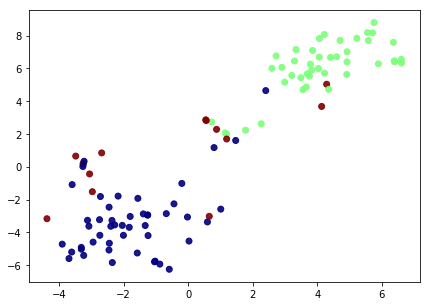

In [220]:
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]
plt.figure(figsize=(7,5))
plt.scatter(node_2d_emb[:,0],node_2d_emb[:,1],c=node_colours, cmap="jet", alpha=0.9)


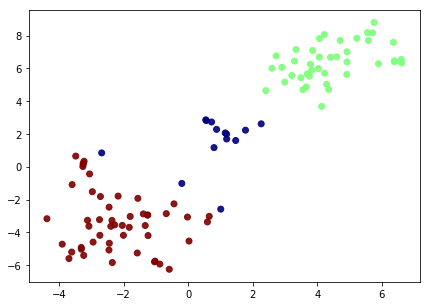

In [221]:
label_map = { l: i for i, l in enumerate(np.unique(df2['cluster']))}
node_colours = [ label_map[target] for target in df2['cluster']]
plt.figure(figsize=(7,5))
plt.scatter(node_2d_emb[:,0],node_2d_emb[:,1],c=node_colours, cmap="jet", alpha=0.9)

# Third Node2Vec

### Node2Vec training

In [222]:
node2vec3 = Node2Vec(G,num_walks=80, dimensions=64, p=1,q=1)

Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████| 80/80 [00:58<00:00,  1.36it/s]


In [223]:
model3 = node2vec3.fit(window=10, min_count=1, batch_words=4)

In [224]:
model3.wv.save_word2vec_format("./model3.txt")

In [225]:
df3 = pd.read_csv('./model3.txt', sep='\s+', index_col=0, header=None, skiprows=1)

In [226]:
df3.index.name = 'named_entity'
print(df3)

                    1         2         3         4         5         6   \
named_entity                                                               
12           -0.216618 -0.102837 -0.096392  0.057456 -0.171112  0.256829   
8            -0.305662  0.064721 -0.173948 -0.007786 -0.109277  0.322155   
3            -0.083173  0.140970 -0.021488  0.130520 -0.041573  0.001137   
84            0.123427 -0.026417  0.403077 -0.082337 -0.029990 -0.157656   
72            0.024989 -0.001178  0.039226 -0.027634  0.092930 -0.104372   
...                ...       ...       ...       ...       ...       ...   
18            0.109653  0.138690  0.109427 -0.054450 -0.161833 -0.078022   
28           -0.204572  0.226916  0.417710 -0.197463  0.098937 -0.329527   
50           -0.317679 -0.228228 -0.127678  0.082294 -0.109651  0.250032   
16           -0.142671  0.225479 -0.027174  0.351799 -0.021322 -0.185086   
103           0.068268 -0.071985  0.218083  0.408669 -0.128598  0.198709   

           

### K Means Clustering

In [227]:
kmeans3 = KMeans(n_clusters=3)

In [228]:
kmeans3.fit(df3)

KMeans(n_clusters=3)

In [229]:
labels = kmeans3.predict(df3)

In [230]:
df3['cluster'] = labels

In [231]:
clusters_df3 = df3.reset_index()[['named_entity','cluster']]

In [232]:
print(clusters_df3)

     named_entity  cluster
0              12        0
1               8        0
2               3        0
3              84        1
4              72        1
..            ...      ...
100            18        0
101            28        1
102            50        0
103            16        0
104           103        2

[105 rows x 2 columns]


### Evaluation

First we get the partition from KMeans algorithm

In [233]:
partition3=[[],[],[]]
for i in range(len(clusters_df3['cluster'])):
    if int(clusters_df3['cluster'][i])==0:
        partition3[0].append(int(clusters_df3['named_entity'][i]))
    elif int(clusters_df3['cluster'][i])==1:
        partition3[1].append(int(clusters_df3['named_entity'][i]))
    else:
        partition3[2].append(int(clusters_df3['named_entity'][i]))

print(partition3)

[[12, 8, 3, 47, 11, 40, 9, 10, 13, 6, 35, 20, 26, 14, 27, 23, 33, 24, 41, 39, 5, 37, 22, 38, 0, 54, 45, 42, 17, 21, 57, 32, 25, 15, 53, 34, 36, 43, 19, 44, 1, 2, 29, 55, 46, 48, 56, 18, 50, 16], [84, 72, 73, 66, 30, 74, 75, 71, 86, 76, 99, 100, 31, 82, 49, 4, 91, 79, 83, 94, 93, 70, 77, 96, 97, 60, 62, 89, 101, 59, 78, 90, 87, 98, 88, 61, 102, 95, 81, 80, 63, 92, 28], [58, 64, 7, 65, 67, 51, 69, 52, 85, 68, 104, 103]]


#### Modularity

In [234]:
print(nx.algorithms.community.modularity(G,partition3))

0.49696114273373754


#### Conductance


In [235]:
print(min(nx.algorithms.cuts.conductance(G, cluster_i, weight='weight') for cluster_i in partition3))

0.0498812351543943


#### Purity

In [236]:
purity=searchCommunity(G.nodes,partition3)
print(purity)

0.8380952380952381


### Visualisation

In [237]:
embedding = np.array(df3.iloc[:,:-1].values.tolist())
ids=df3.index.tolist()
node_targets = [G.nodes[int(node_id)]['value'] for node_id in ids]

In [238]:
tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random')
node_2d_emb=tsne.fit_transform(embedding)

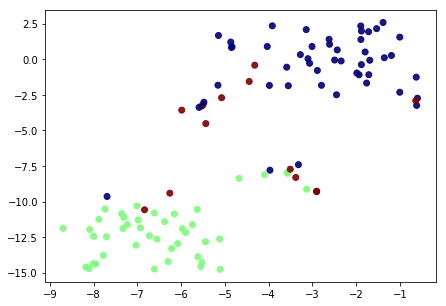

In [239]:
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]
plt.figure(figsize=(7,5))
plt.scatter(node_2d_emb[:,0],node_2d_emb[:,1],c=node_colours, cmap="jet", alpha=0.9)


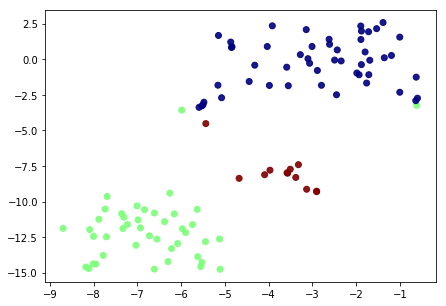

In [240]:
label_map = { l: i for i, l in enumerate(np.unique(df3['cluster']))}
node_colours = [ label_map[target] for target in df3['cluster']]
plt.figure(figsize=(7,5))
plt.scatter(node_2d_emb[:,0],node_2d_emb[:,1],c=node_colours, cmap="jet", alpha=0.9)